### Homework: going neural (6 pts)

We've checked out statistical approaches to language models in the last notebook. Now let's go find out what deep learning has to offer.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/expanding_mind_lm_kn_3.png' width=300px>

We're gonna use the same dataset as before, except this time we build a language model that's character-level, not word level. Before you go:
* If you haven't done seminar already, use `seminar.ipynb` to download the data.
* This homework uses TensorFlow v2.0: this is [how you install it](https://www.tensorflow.org/beta); and that's [how you use it](https://colab.research.google.com/drive/1YtfbZGgzKr7fpBTqkdEQtu4vUALoTv8A).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Working on character level means that we don't need to deal with large vocabulary or missing words. Heck, we can even keep uppercase words in text! The downside, however, is that all our sequences just got a lot longer.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.


In [2]:
BOS, EOS = ' ', '\n'


!wget "https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1" -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

# if you missed the seminar, download data here - https://yadi.sk/d/_nGyU2IajjR9-w

--2019-10-08 18:25:11--  https://www.dropbox.com/s/99az9n1b57qkd9j/arxivData.json.tar.gz?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz [following]
--2019-10-08 18:25:12--  https://www.dropbox.com/s/dl/99az9n1b57qkd9j/arxivData.json.tar.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc0052bedf36fe1b119868b44264.dl.dropboxusercontent.com/cd/0/get/AqDGB33kXf2DYGr-yK9kydv43q4jVIW52-LghOyYhpCMwiCGHXKSVexR8bi88UFmkk9gbl6aDITFrS7KAY6Fp1dZ6SWi43M9s91xx2o6HvbIDQ/file?dl=1# [following]
--2019-10-08 18:25:12--  https://uc0052bedf36fe1b119868b44264.dl.dropboxusercontent.com/cd/0/get/AqDGB33kXf2DYGr-yK9kydv43q4jVIW52-LghOyYhpCMwiCGHXKSVexR8bi88UFmkk9gbl6aDITFrS7KAY6Fp1dZ6SWi43M9s91xx2o6Hv

Our next step is __building char-level vocabulary__. Put simply, you need to assemble a list of all unique tokens in the dataset.

In [4]:
# get all unique characters from lines (including capital letters and symbols)
tokens = list({char for line in lines for char in line})

tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens

n_tokens =  136


We can now assign each character with it's index in tokens list. This way we can encode a string into a TF-friendly integer vector.

In [0]:
# dictionary of character -> its identifier (index in tokens list)
token_to_id = {char:ind for ind, char in enumerate(tokens)}

In [6]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


Our final step is to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [0]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype='int32'):
    """Casts a list of lines into tf-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [8]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))



[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]


### Neural Language Model

Just like for N-gram LMs, we want to estimate probability of text as a joint probability of tokens (symbols this time).

$$P(X) = \prod_t P(x_t \mid x_0, \dots, x_{t-1}).$$ 

Instead of counting all possible statistics, we want to train a neural network with parameters $\theta$ that estimates the conditional probabilities:

$$ P(x_t \mid x_0, \dots, x_{t-1}) \approx p(x_t \mid x_0, \dots, x_{t-1}, \theta) $$


But before we optimize, we need to define our neural network. Let's start with a fixed-window (aka convolutional) architecture:

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/fixed_window_lm.jpg' width=400px>


In [9]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
import tensorflow as tf

keras, L = tf.keras, tf.keras.layers
assert tf.__version__.startswith('2'), "Current tf version: {}; required: 2.0.*".format(tf.__version__)

In [0]:
class FixedWindowLanguageModel(L.Layer):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=64):
        """ 
        A fixed window model that looks on at least 5 previous symbols.
        
        Note: fixed window LM is effectively performing a convolution over a sequence of words.
        This convolution only looks on current and previous words.
        Such convolution can be represented as a sequence of 2 operations:
        - pad input vectors by {strides * (filter_size - 1)} zero vectors on the "left", do not pad right
        - perform regular convolution with {filter_size} and {strides}
        - If you're absolutely lost, here's a hint: use ZeroPadding1D and Conv1D from keras.layers
        You can stack several convolutions at once
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        #YOUR CODE - create layers/variables and any metadata you want, e.g. self.emb = L.Embedding(...)
        filter_size = 5
        strides = 1
        padding_size = strides * (filter_size - 1)
        self.n_tokens = n_tokens
        
        self.emb = L.Embedding(self.n_tokens, emb_size)
        self.pad = L.ZeroPadding1D(padding=(padding_size, 0))
        self.conv = L.Conv1D(filters=hid_size, kernel_size=filter_size, strides=strides)
        self.dense = L.Dense(self.n_tokens)
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        # YOUR CODE - apply layers, see docstring above
        
        
        input_ix = tf.expand_dims(input_ix, 2)
        padded = self.pad(input_ix)
        padded = tf.squeeze(padded, axis=2)
        
        x = self.emb(padded)
        x = self.conv(x)
        x = self.dense(x)
        
        return x
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = tf.convert_to_tensor(to_matrix([prefix]), tf.int32)
        probs = tf.nn.softmax(self(prefix_ix)[0, -1]).numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [39]:
model = FixedWindowLanguageModel()

# note: tensorflow and keras layers create variables only after they're first applied (called)
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_logits = model(dummy_input_ix)

print('Weights:', tuple(w.name for w in model.trainable_variables))

Weights: ('embedding_1/embeddings:0', 'conv1d_1/kernel:0', 'conv1d_1/bias:0', 'dense_1/kernel:0', 'dense_1/bias:0')


In [0]:
assert isinstance(dummy_logits, tf.Tensor)
assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [0]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_logits_2 = model(dummy_input_ix_2)

assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.

In [42]:
def compute_lengths(input_ix, eos_ix=token_to_id[EOS]):
    """ compute length of each line in input ix (incl. first EOS), int32 vector of shape [batch_size] """
    count_eos = tf.cumsum(tf.cast(tf.equal(input_ix, eos_ix), tf.int32), axis=1, exclusive=True)
    lengths = tf.reduce_sum(tf.cast(tf.equal(count_eos, 0), tf.int32), axis=1)
    return lengths

print('matrix:\n', dummy_input_ix.numpy())
print('lengths:', compute_lengths(dummy_input_ix).numpy())

matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
lengths: [ 5  9 15]


In [0]:
def compute_loss(model, input_ix):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    """
    input_ix = tf.convert_to_tensor(input_ix, dtype=tf.int32)
    

    logits = model(input_ix[:, :-1])
    reference_answers = input_ix[:, 1:]

    # Your task: implement loss function as per formula above
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # you will likely need to use compute_lengths and/or tf.sequence_mask to get it right.
    lengths = compute_lengths(input_ix)
    mask = tf.sequence_mask(lengths, reference_answers.shape[1])
    
    reference_answers = tf.boolean_mask(reference_answers, mask)
    reference_answers = tf.one_hot(reference_answers, model.n_tokens)
    
    logits = tf.boolean_mask(logits, mask)
    
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(reference_answers, logits)
    loss = tf.math.reduce_mean(cross_entropy)
    
    return loss

In [108]:
reference_answers, logits = compute_loss(model, to_matrix(dummy_lines, max_len=50))
reference_answers.shape, logits.shape

(TensorShape([29, 136]), TensorShape([29, 136]))

In [110]:
compute_loss(model, to_matrix(dummy_lines, max_len=50))

<tf.Tensor: id=2100, shape=(), dtype=float32, numpy=4.9104056>

In [0]:
loss_1 = compute_loss(model, to_matrix(dummy_lines, max_len=50))
loss_2 = compute_loss(model, to_matrix(dummy_lines, max_len=100))
assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"
assert np.allclose(loss_1, loss_2), 'do not include  AFTER first EOS into loss. '\
    'Hint: use tf.sequence_mask. Beware +/-1 errors. And be careful when averaging!'

### Evaluation

You will need two functions: one to compute test loss and another to generate samples. For your convenience, we implemented them both in your stead.

In [0]:
def score_lines(model, dev_lines, batch_size):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
        batch_ix = to_matrix(dev_lines[i: i + batch_size])
        dev_loss_num += compute_loss(model, batch_ix) * len(batch_ix)
        dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

def generate(model, prefix=BOS, temperature=1.0, max_len=100):
    """
    Samples output sequence from probability distribution obtained by model
    :param temperature: samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    while True:
        token_probs = model.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

### Training loop

Finally, let's train our model on minibatches of data

In [115]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []
optimizer = keras.optimizers.Adam()

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

Sample before training: BridgingEi°ó<v:zFVy=nZRèŁRÜ<αRs;É(k5y#Jtgüo1s;íA\ś#I(_]Z]Ωś#'>MJF°ÉγjvLiöαyèSEś3:ΣTfRàI>Jnwõ\"mXèHçô


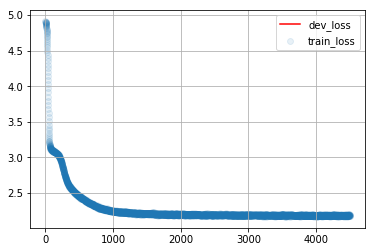

Generated examples (tau=0.5):
 Sepers and chere te ropricand at and ing bath thes and cound of omely an whed bes dotthe werks ; The
 Atsy ale bation ing of coner destin the propesticl cont. The exproses ing tres en for anc uration th


 90%|█████████ | 4500/5000 [1:08:54<10:09,  1.22s/it]

 A Tha nof and ho prore fore tich se monthis palain ifer ant of the tion al araly the s on the peatio


 91%|█████████ | 4529/5000 [1:09:20<06:51,  1.14it/s]

KeyboardInterrupt: ignored

In [116]:
from IPython.display import clear_output
from random import sample
from tqdm import trange

for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    with tf.GradientTape() as tape:
        loss_i = compute_loss(model, batch)
        
    grads = tape.gradient(loss_i, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_history.append((i, loss_i.numpy()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for i in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [117]:
assert np.mean(train_history[:10], axis=0)[1] > np.mean(train_history[-10:], axis=0)[1], "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])

for i in range(10):
    print(generate(model, temperature=0.5))

Final dev loss: tf.Tensor(4.914094, shape=(), dtype=float32)
 A probation sidiangy sion dore vitume track or he chion the selalizize as inghe the sing ine cof co 
 Montict of andesto sulto s for image de pation as on the pares ; We prestint in armale dusconsing in
 Experis inf or the s problenderestee tor ise the sempline fore thane works ingerond and che seral in
 Proplicinticall arnered on the tha d anc antion mancl are tod ing pares the dal work or he probler t
 Deromint Dictist contichis al seathe suret of led-iand coproto the s of the s are mate tarking A Clo
 A Nentor bees th se torible probe mation that of extion the thed ine raperted templering the pere wo
 Constion seston are the suac inge doned and ro tho sion dfor the seprove to nof imation profaction t
 Preting arign as une Coull and cha d oretrod of te tha de phevore that on the perechale works roproc
 Frecentrack. Howhid teer ane the lo ur the se fortict or ho which ure teco se the roplotion tho n Tr
 Deppes ar intor the 

### RNN Language Models

Fixed-size architectures are reasonably good when capturing short-term dependencies, but their design prevents them from capturing any signal outside their window. We can mitigate this problem by using a __recurrent neural network__:

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>

In [0]:
class RNNLanguageModel(L.Layer):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=256):
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        """
        super().__init__() # initialize base class to track sub-layers, trainable variables, etc.
        
        # YOUR CODE - create layers/variables/etc
        
        <...>
        
        #END OF YOUR CODE
    
    def __call__(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        #YOUR CODE
        return <...>
    
    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_ix = tf.convert_to_tensor(to_matrix([prefix]), tf.int32)
        probs = tf.nn.softmax(self(prefix_ix)[0, -1]).numpy()  # shape: [n_tokens]
        return dict(zip(tokens, probs))
        

In [0]:
rnn_lm = RNNLanguageModel()

In [0]:
dummy_input_ix = tf.constant(to_matrix(dummy_lines))
dummy_lm_out = rnn_lm(dummy_input_ix)
# note: tensorflow and keras layers only create variables after they're first applied (called)

sess.run(tf.global_variables_initializer())
dummy_logits = sess.run(dummy_lm_out)

assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits)), "inf/nan encountered"
assert not np.allclose(dummy_logits.sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

In [0]:
# test for lookahead
dummy_input_ix_2 = tf.constant(to_matrix([line[:3] + 'e' * (len(line) - 3) for line in dummy_lines]))
dummy_lm_out_2 = rnn_lm(dummy_input_ix_2)
dummy_logits_2 = sess.run(dummy_lm_out_2)
assert np.allclose(dummy_logits[:, :3] - dummy_logits_2[:, :3], 0), "your model's predictions depend on FUTURE tokens. " \
    " Make sure you don't allow any layers to look ahead of current token." \
    " You can also get this error if your model is not deterministic (e.g. dropout). Disable it for this test."

### RNN training

Our RNN language model should optimize the same loss function as fixed-window model. But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [ruining](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/clip_by_global_norm).

Your task here is to prepare tensorflow graph that would minimize the same loss function. If you encounter large loss fluctuations during training, please add gradient clipping using urls above.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [0]:
batch_size = 64         # <-- please tune batch size to fit your CPU/GPU configuration
score_dev_every = 250
train_history, dev_history = [], []
optimizer = keras.optimizers.Adam()

# score untrained model
dev_history.append((0, score_lines(model, dev_lines, batch_size)))
print("Sample before training:", generate(model, 'Bridging'))

In [0]:
for i in trange(len(train_history), 5000):
    batch = to_matrix(sample(train_lines, batch_size))
    
    with tf.GradientTape() as tape:
        loss_i = compute_loss(model, batch)
        
    grads = tape.gradient(loss_i, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_history.append((i, loss_i.numpy()))
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        for i in range(3):
            print(generate(model, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(model, dev_lines, batch_size)))
        print('#%i Dev loss: %.3f' % dev_history[-1])


In [0]:
assert np.mean(train_history[:10]) > np.mean(train_history[-10:]), "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_lm, temperature=0.5))

### Bonus quest: Ultimate Language Model

So you've learned the building blocks of neural language models, you can now build the ultimate monster:  
* Make it char-level, word level or maybe use sub-word units like [bpe](https://github.com/rsennrich/subword-nmt);
* Combine convolutions, recurrent cells, pre-trained embeddings and all the black magic deep learning has to offer;
  * Use strides to get larger window size quickly. Here's a [scheme](https://storage.googleapis.com/deepmind-live-cms/documents/BlogPost-Fig2-Anim-160908-r01.gif) from google wavenet.
* Train on large data. Like... really large. Try [1 Billion Words](http://www.statmt.org/lm-benchmark/1-billion-word-language-modeling-benchmark-r13output.tar.gz) benchmark;
* Use training schedules to speed up training. Start with small length and increase over time; Take a look at [one cycle](https://medium.com/@nachiket.tanksale/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6) for learning rate;

_You are NOT required to submit this assignment. Please make sure you don't miss your deadline because of it :)_